In [1]:
import pandas as pd
import requests
import os
import re
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import random

**Only need this function if you don't want to use the csv files I write for some reason**

In [2]:
# #side refers to either "offense" or "defense" in this case
# def scrape_stats(side): 
#     url = f"https://www.nfl.com/stats/team-stats/{side}/passing/2022/reg/all"
#     #get the page
#     page = requests.get(url)
#     #check for errors, raise exception if error
#     page.raise_for_status()
#     #get the table with the team stats
#     df = pd.read_html(page.text)[0]
#     #get the team names column as when scraping the team name is repeated (Ex: SeahawksSeahawks) as it 
#     #is consolidating the logo and team name column into one column
#     names_list = list(df["Team"])
#     #new list to store edited team names
#     edited_names = []
#     #loop through all the teams and use regex to replace SeahawksSeahawks with Seahawks 
#     for i in names_list:
#         #49ers are only team with a number so need the OR statement to handle them
#         name = re.findall('([A-Z][^A-Z]*|49ers)', i)[0] #take the first value in the list
#         #append to list
#         edited_names.append(name)
#     #replace Team column with the edited names
#     df["Team"] = edited_names
#     #return df with edited names
#     return(df)

In [3]:
# if not os.path.exists("2022_offense.csv"):
#     offense_2022 = scrape_stats("offense")
#     offense_2022.to_csv("2022_offense.csv", index=False)
# else:
#     print("File names 2022_offense.csv already exists")

In [4]:
# if not os.path.exists("2022_defense.csv"):
#     defense_2022 = scrape_stats("defense")
#     defense_2022.to_csv("2022_defense.csv", index=False)
# else:
#     print("File names 2022_defense.csv already exists")

**Organize Data**

In [5]:
#read csv files
o = pd.read_csv("2022_offense.csv")
d = pd.read_csv("2022_defense.csv")
#rename columns
o = o.rename(columns={"Yds/Att": "Y/A"})
d = d.rename(columns={"Yds/Att": "Defense Y/A"})
#take only desired columns
o = o[["Team", "Y/A"]]
d = d[["Team", "Defense Y/A"]]
#combine dfs
combined = pd.merge(o, d, on="Team")
#add net_ya column
combined["Net Y/A"] = combined["Y/A"] - combined["Defense Y/A"]
combined.head()

,Team,Y/A,Defense Y/A,Net Y/A
0,Buccaneers,6.3,6.1,0.2
1,Chargers,6.7,6.7,0.0
2,Vikings,7.2,7.3,-0.1
3,Cardinals,6.0,6.6,-0.6
4,Chiefs,8.1,6.1,2.0


In [6]:
#read file with 2022 records
records = pd.read_csv("2022_records.csv")
records["Win Percentage"] = (2 * (records["Wins"] + records["Ties"]))  /  (2 * (records["Wins"] + records["Ties"] + records["Losses"]))
records.head()
#merge Y/A with records
final = pd.merge(combined, records, on="Team")
final.head()

,Team,Y/A,Defense Y/A,Net Y/A,Wins,Losses,Ties,Win Percentage
0,Buccaneers,6.3,6.1,0.2,8,9,0,0.470588
1,Chargers,6.7,6.7,0.0,10,7,0,0.588235
2,Vikings,7.2,7.3,-0.1,13,4,0,0.764706
3,Cardinals,6.0,6.6,-0.6,4,13,0,0.235294
4,Chiefs,8.1,6.1,2.0,14,3,0,0.823529


**Analysis and Visualizations**

In [7]:
lr = LinearRegression()
lr.fit(final[["Net Y/A"]], final["Win Percentage"])
slope = lr.coef_[0]
intercept = lr.intercept_
slope, intercept

(0.1260351556799086, 0.44366219940872065)

In [8]:
final["Net Y/A"].corr(final["Win Percentage"])

0.5851005139718073

**As we can see from an r value of .585 we have a moderately strong correlation between Net Y/A and Win percentage for the 2022 season**

In [9]:
playoff_teams = ["Eagles", "49ers", "Vikings", "Buccaneers", "Cowboys", "Giants", "Seahawks", "Chiefs", "Bills",
                "Bengals", "Jaguars", "Chargers", "Ravens", "Dolphins"]
#filter df so it is only the playoff teams
playoff = final[final["Team"].isin(playoff_teams)] 
playoff

,Team,Y/A,Defense Y/A,Net Y/A,Wins,Losses,Ties,Win Percentage
0,Buccaneers,6.3,6.1,0.2,8,9,0,0.470588
1,Chargers,6.7,6.7,0.0,10,7,0,0.588235
2,Vikings,7.2,7.3,-0.1,13,4,0,0.764706
4,Chiefs,8.1,6.1,2.0,14,3,0,0.823529
6,Bengals,7.4,6.6,0.8,12,4,0,0.750000
8,Jaguars,7.0,6.8,0.2,9,8,0,0.529412
11,Dolphins,8.2,6.4,1.8,9,8,0,0.529412
13,Bills,7.5,6.0,1.5,13,3,0,0.812500
14,Seahawks,7.5,6.6,0.9,9,8,0,0.529412
18,Cowboys,7.0,6.2,0.8,12,5,0,0.705882


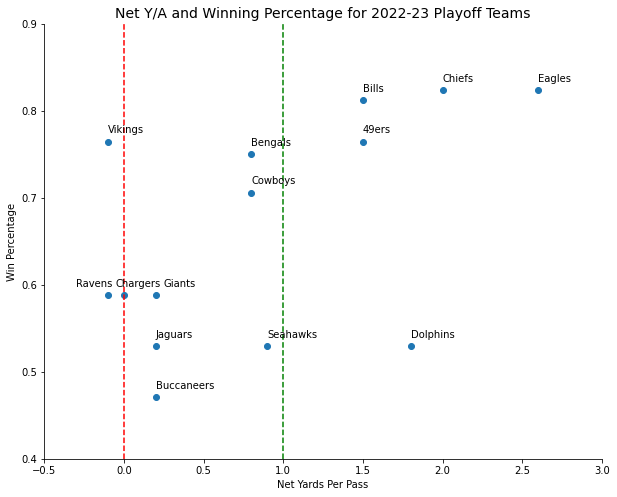

In [10]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(x=playoff["Net Y/A"], y=playoff["Win Percentage"])
plt.ylim([.4,.9])
plt.xlim([-.5, 3])
ax.set_xlabel("Net Yards Per Pass")
ax.set_ylabel("Win Percentage")

for i in range(len(playoff)):
    #adding the random component is just to jitter the points in case of overlap it doesn't change anything
    team = playoff.iloc[i]["Team"]
    #These if statements are for labels that would overlap without modifying their coordinates
    if team == "Ravens":
        ax.annotate(playoff.iloc[i]["Team"], xy = (float(playoff.iloc[i]["Net Y/A"]) - 0.2, 
                                             (float(playoff.iloc[i]["Win Percentage"]) + 0.01)))
    elif team == "Chargers":
        ax.annotate(playoff.iloc[i]["Team"], xy = (float(playoff.iloc[i]["Net Y/A"]) - 0.05, 
                                             (float(playoff.iloc[i]["Win Percentage"]) + 0.01)))
    elif team == "Giants":
        ax.annotate(playoff.iloc[i]["Team"], xy = (float(playoff.iloc[i]["Net Y/A"]) + .05, 
                                             (float(playoff.iloc[i]["Win Percentage"]) + 0.01)))  
    #for all other teams just move the text up a little bit so it is above the point
    else:
        ax.annotate(playoff.iloc[i]["Team"], xy = (float(playoff.iloc[i]["Net Y/A"]), 
                                             (float(playoff.iloc[i]["Win Percentage"])) + 0.01))

plt.title("Net Y/A and Winning Percentage for 2022-23 Playoff Teams", fontdict={'fontsize': 14})
plt.axvline(x=0, linestyle="--", color="red")
plt.axvline(x=1, linestyle="--", color="green")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
None